# Convolution Neural Network

This example shows how to do image classification from scratch, starting from JPEG image files on disk, without leveraging pre-trained weights or a pre-made Keras Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary classification dataset.

## Importing libraries

In [61]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# class ImageDataGenerator: Generate batches of tensor image data with real-time data augmentation.
# Deprecated in TensorFlow v2.9.3
# https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image

In [62]:
print(tf.__version__)

2.17.0


## Data Preprocessing

### Preprocessing the Training set

The purpose to do transformations on the training images set is to avoid overfitting.

#### Data Augmentation

Data augmentation artificially increses the size of the training set by generating many realistic variants of each training instance. This reduces overfitting, making this a **regularization technique**.
This forces the model to be more tolerant to variations in the position, orientation, and size of the objects in the pictures.


#### Transformations
* [shear_range](https://keras.io/api/keras_cv/layers/augmentation/random_shear/)
* [zoom_range](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_zoom/)
* [horizontal_flip](https://keras.io/2.16/api/layers/preprocessing_layers/image_augmentation/random_flip/)

#### ImageDataGenerator **Deprecated**

>Deprecated: [tf.keras.preprocessing](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/preprocessing) APIs do not operate on tensors and are not recommended for new code. Prefer loading data with either [tf.keras.utils.text_dataset_from_directory](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/utils/text_dataset_from_directory) or [tf.keras.utils.image_dataset_from_directory](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/utils/image_dataset_from_directory), and then transforming the output [tf.data.Dataset](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/data/Dataset) with preprocessing layers. These approaches will offer better performance and intergration with the broader Tensorflow ecosystem. For more information, see the tutorials for [loading text](https://www.tensorflow.org/tutorials/load_data/text), [loading images](https://www.tensorflow.org/tutorials/load_data/images), and [augmenting images](https://www.tensorflow.org/tutorials/images/data_augmentation), as well as the [preprocessing layer guide](https://www.tensorflow.org/guide/keras/preprocessing_layers).

# Load the data: the Cats and Dogs dataset

In [63]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/training_set", # Directory where the data is located. If labels is "inferred", it should contain subdirectories, each containing images for a class.
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(64, 64), 
    batch_size=32,
    color_mode="rgb",
    label_mode="int"
)

Found 8000 files belonging to 2 classes.
Using 6400 files for training.


In [64]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/training_set", # Directory where the data is located. If labels is "inferred", it should contain subdirectories, each containing images for a class.
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(64, 64), 
    batch_size=32,
    color_mode="rgb",
    label_mode="int"
)

Found 8000 files belonging to 2 classes.
Using 1600 files for validation.


## Verifying if dataset is imbalanced

In [65]:
class_names = train_ds.class_names 
print(class_names) # match names of subdirectories

['cats', 'dogs']


The image_batch is a tensor of the shape (32, 64, 64, 3). This is a batch of 32 images of shape 64x64x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [66]:
count_dogs = 0
count_cats = 0

for image_batch, labels_batch in train_ds:
    count_dogs += np.count_nonzero(labels_batch.numpy()==0)
    count_cats += np.count_nonzero(labels_batch.numpy()==1)

print(f"count dogs: {count_dogs}\ncount cats: {count_cats}")
print(f"Total: {count_dogs+count_cats}")

count dogs: 3180
count cats: 3220
Total: 6400


Above we can see that our dataset is balanced

# Visualize the data

The image quality is bad because we resized the images to 64 x 64.

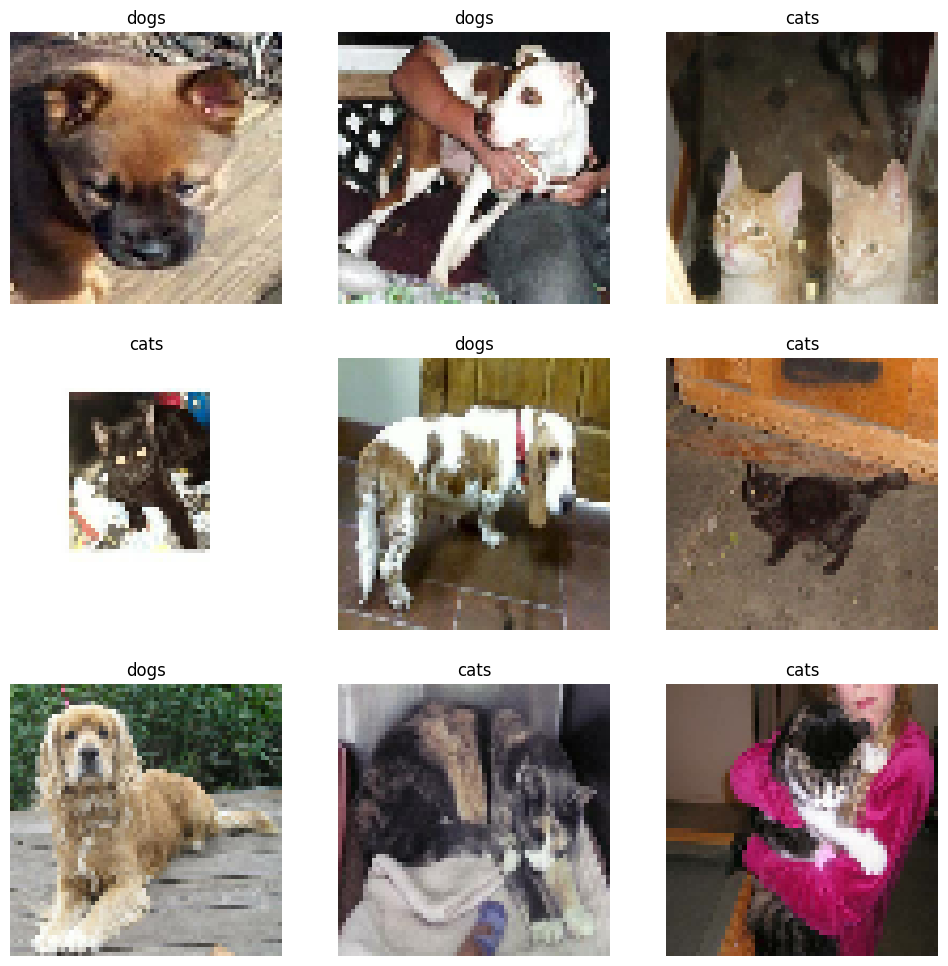

In [67]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1): # first batch of 32 images 
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1) # 3x3=9
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Using image data augmentation

The purpose to do transformations on the training images set is to avoid overfitting.

**Data augmentation** artificially increses the size of the training set by generating many realistic variants of each training instance. This reduces overfitting, making this a **regularization technique**.
This forces the model to be more tolerant to variations in the position, orientation, and size of the objects in the pictures. 

Many examples utilize the ```ImageDataGenerator``` for loading data and performing data augmentation. However, acording to the TensorFlow documentation, this class was [deprecated in TensorFlow v2.9.3](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/preprocessing).

#### ImageDataGenerator **Deprecated**

>Deprecated: [tf.keras.preprocessing](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/preprocessing) APIs do not operate on tensors and are not recommended for new code. Prefer loading data with either [tf.keras.utils.text_dataset_from_directory](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/utils/text_dataset_from_directory) or [tf.keras.utils.image_dataset_from_directory](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/utils/image_dataset_from_directory), and then transforming the output [tf.data.Dataset](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/data/Dataset) with preprocessing layers. These approaches will offer better performance and intergration with the broader Tensorflow ecosystem. For more information, see the tutorials for [loading text](https://www.tensorflow.org/tutorials/load_data/text), [loading images](https://www.tensorflow.org/tutorials/load_data/images), and [augmenting images](https://www.tensorflow.org/tutorials/images/data_augmentation), as well as the [preprocessing layer guide](https://www.tensorflow.org/guide/keras/preprocessing_layers).


In [81]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2)
])

augmented_trains_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
augmented_val_ds = val_ds.map(lambda x, y: (data_augmentation(x), y))

In [82]:
for image_batch, labels_batch in augmented_trains_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 64, 64, 3)
(32,)


tf.Tensor([1 0 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 1 1 1 0], shape=(32,), dtype=int32)


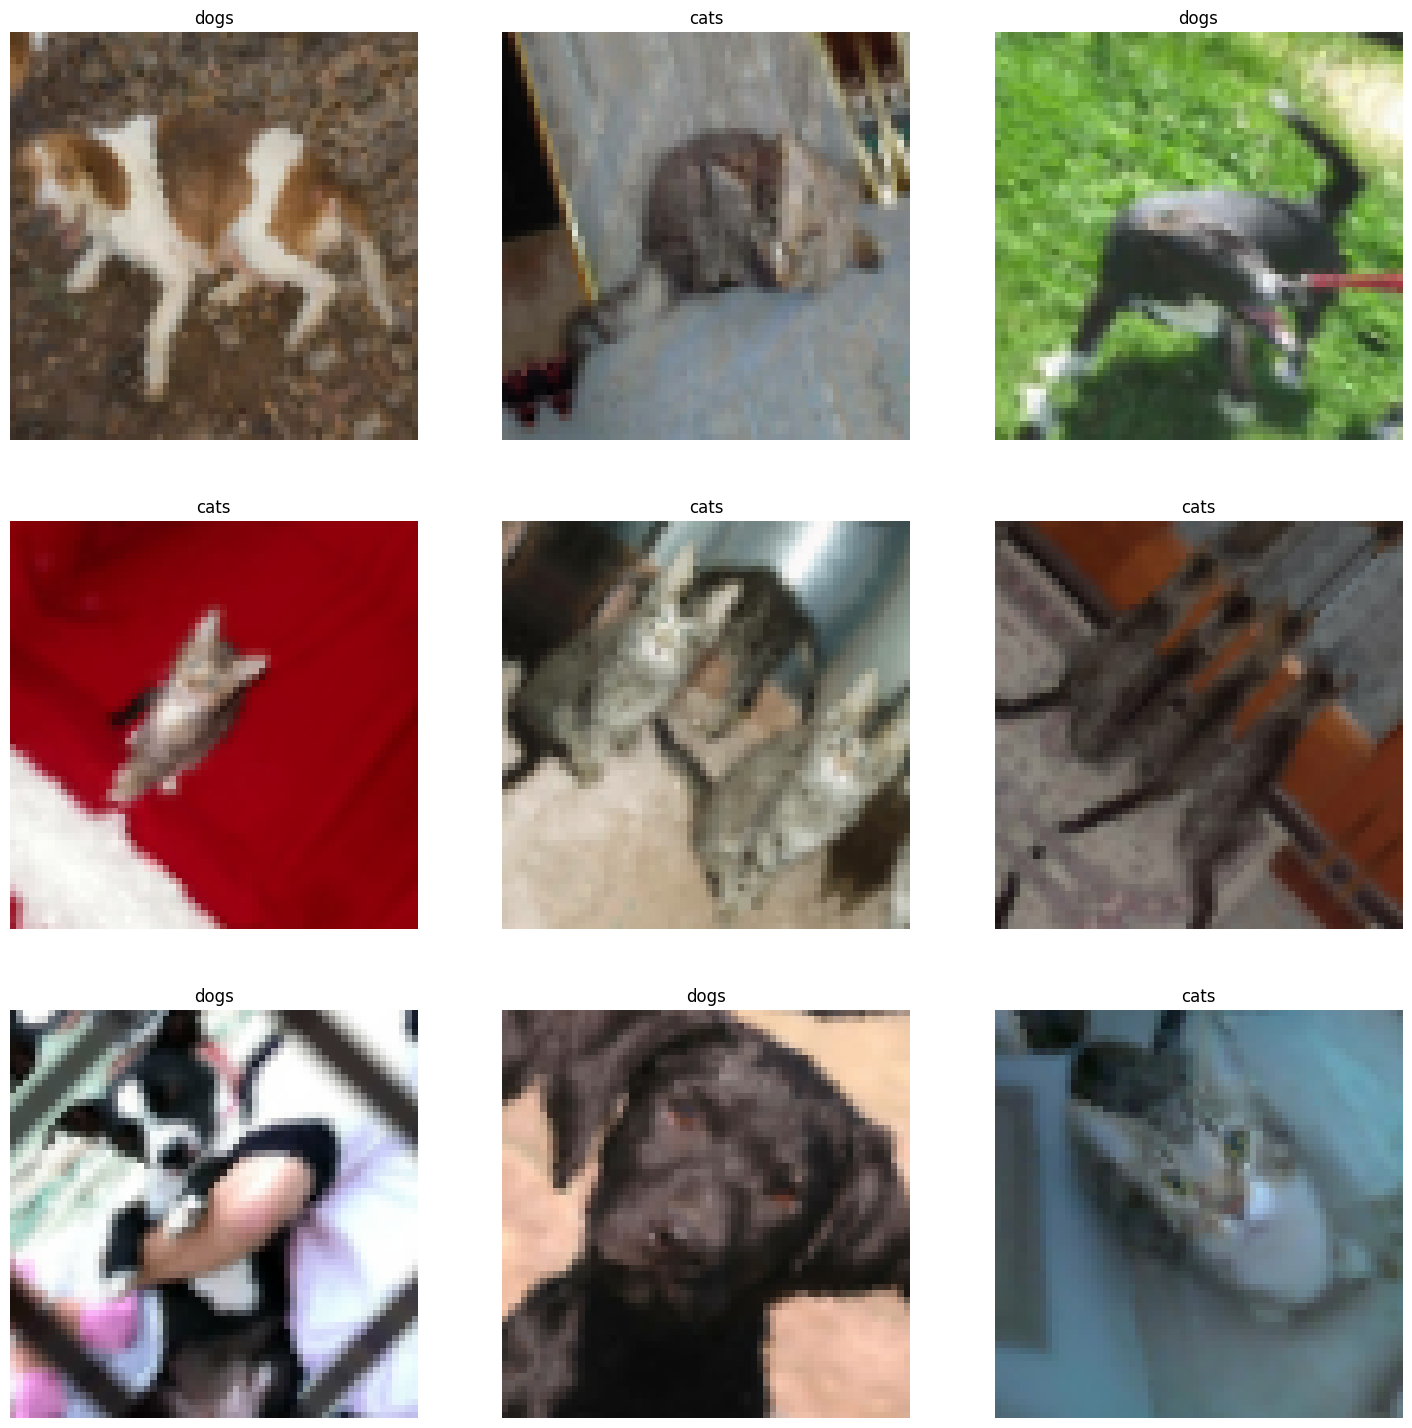

In [83]:
plt.figure(figsize=(18, 18))
for images, labels in augmented_trains_ds.take(1): # first batch of 32 images 
  print(labels)  
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1) 
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Build a model

In [72]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Input(shape=(64, 64, 3))) # https://keras.io/api/layers/core_layers/input/
cnn.add(tf.keras.layers.Rescaling(1./255))

Applying rescaling (such as Rescaling(1./255)) to images is a common practice in convolutional neural networks (CNNs). This is because image pixel values typically range from 0 to 255, and rescaling normalizes these values to a range between 0 and 1, which helps the model train more effectively.

This normalization is beneficial because:

1. **Reduces data scale:** Keeping values between 0 and 1 prevents numerical issues, such as overly large gradients, which can cause instability during training.
2. **Ensures consistency:** Most activation functions, like ReLU, perform better when the input data is within a small, consistent range.
3. **Speeds up learning:** Normalizing inputs can enhance the optimizer's efficiency, resulting in faster training.

In [ ]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"))

The convolution layer will have 32 filters (kernels) with dimension 3x3.

<img src="images\convolution-filters.png" alt="conv-filters" width="70%"/>

In [73]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2))

<img src="images\max-pooling.png" alt="max-pooling" width="70%"/>

In [74]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

In [75]:
cnn.add(tf.keras.layers.Flatten())

<img src="images\flatten.png" alt="flatten" width="70%"/>

In [76]:
cnn.add(tf.keras.layers.Dense(units=128, activation="relu"))
cnn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

After adding all the layers, our CNN will look like the image below.

<img src="images\CNN-architecture-composed-of-5-convolutional-layers-with-128-feature-maps-3-dense-layers.png" alt="cnn-complete" width="70%"/>

# Train the model

In [77]:
cnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
cnn.fit(x=augmented_trains_ds, validation_data=augmented_val_ds, epochs=50)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.5330 - loss: 0.7026 - val_accuracy: 0.6381 - val_loss: 0.6253
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.6416 - loss: 0.6323 - val_accuracy: 0.7044 - val_loss: 0.5968
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.6931 - loss: 0.5883 - val_accuracy: 0.7019 - val_loss: 0.5664
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.7207 - loss: 0.5510 - val_accuracy: 0.7381 - val_loss: 0.5227
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.7506 - loss: 0.5044 - val_accuracy: 0.7331 - val_loss: 0.5284
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.7613 - loss: 0.4941 - val_accuracy: 0.7231 - val_loss: 0.5611
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.7686 - loss: 0.4723 - val_accuracy: 0.7631 - val_loss: 0.4836
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.7919 - loss: 0.4444 - 

# Run inference on new data

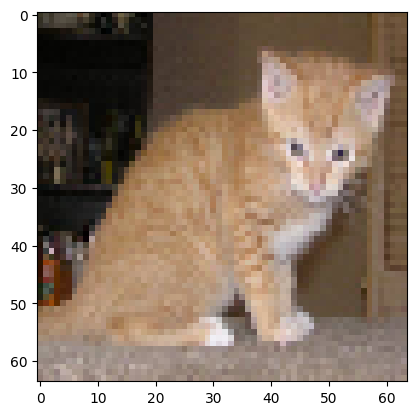

In [78]:
test_image = image.load_img("dataset/single_prediction/cat.4003.jpg", target_size = (64, 64)) # has to be same size -> cnn.add(tf.keras.layers.Input(shape=(64, 64, 3)))
plt.imshow(test_image)

test_image = image.img_to_array(test_image) # converting PIL into an array

In [79]:
test_image = np.expand_dims(test_image, axis=0) # create batch axis

The command np.expand_dims(test_image, axis=0) is used to add a new dimension to the image array, transforming it from a single image into a batch of images.

This is necessary because most convolutional neural networks (CNNs), including those implemented in frameworks like TensorFlow and Keras, expect input data for prediction or training to be provided in batches, even if there is only one image. In other words, the network typically expects input in a 4-dimensional format, which represents a batch of images.

These dimensions are usually:

* Batch size (number of images in the batch)
* Height of the image
* Width of the image
* Number of channels (e.g., 1 for grayscale or 3 for RGB)
  
If you have a single image with dimensions (height, width, channels), the command np.expand_dims(test_image, axis=0) adds the "batch size" dimension, converting it to the expected format: (1, height, width, channels).

This new format allows the CNN to process the image correctly during prediction, even though you're passing only one image instead of a batch.

In [80]:
result = cnn.predict(test_image)

# 1 = dog
# 0 = cat
print(result[0][0])
if result[0][0] > 0.5:
    print("dog")
else:
    print("cat")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
0.3671397
cat


# References

* https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory
* https://keras.io/api/data_loading/image/
* https://www.tensorflow.org/tutorials/images/data_augmentation
* https://www.tensorflow.org/tutorials/images/classification
* https://medium.com/@seelcs12/cnns-for-imbalanced-image-classification-with-tensorflow-7284a8c4a2e4
* https://e2eml.school/how_convolutional_neural_networks_work.html
* https://medium.com/advanced-deep-learning/cnn-operation-with-2-kernels-resulting-in-2-feature-mapsunderstanding-the-convolutional-filter-c4aad26cf32
* https://keras.io/examples/vision/image_classification_from_scratch/